In [1]:
import os
import math
import random
import numpy as np
import librosa
import kagglehub
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
import matplotlib.pyplot as plt
import seaborn as sns

## Download GTZAN Dataset

In [2]:
print("Downloading GTZAN dataset...")
data_path = kagglehub.dataset_download("andradaolteanu/gtzan-dataset-music-genre-classification")
DATASET_PATH = os.path.join(data_path, "Data", "genres_original")
print("Dataset path:", DATASET_PATH)

Using Colab cache for faster access to the 'gtzan-dataset-music-genre-classification' dataset.
Dataset path: /kaggle/input/gtzan-dataset-music-genre-classification/Data/genres_original


## CONFIG

In [3]:
SR = 22050
DURATION = 30
SAMPLES = SR * DURATION
N_FFT = 2048
HOP_LENGTH = 512
N_MELS = 128
EXPECTED_FRAMES = int(np.ceil(SAMPLES / HOP_LENGTH))  # ~1290
RANDOM_SEED = 42
BATCH_SIZE = 32
EPOCHS = 100
MODEL_SAVE = "gtzan_best.h5"
USE_AUGMENT = True
USE_SPEC_AUG = True
MODEL_TYPE = "cnn_bilstm"  # "cnn" or "cnn_bilstm"
AUGMENT_COPIES = 3

random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)


## Augmentation Helpers

In [4]:
def time_stretch(waveform, low=0.9, high=1.1):
    rate = np.random.uniform(low, high)
    try:
        return librosa.effects.time_stretch(waveform, rate)
    except Exception:
        return waveform

def pitch_shift(waveform, sr=SR, n_steps_low=-2, n_steps_high=2):
    n_steps = np.random.randint(n_steps_low, n_steps_high + 1)
    try:
        return librosa.effects.pitch_shift(waveform, sr, n_steps)
    except Exception:
        return waveform

def apply_wave_augmentations(y):
    if random.random() < 0.4:
        y = pitch_shift(y)
    if random.random() < 0.3:
        y = time_stretch(y)
    return y

def spec_augment(mel, num_masks=2, freq_mask_param=18, time_mask_param=40):
    """Simple SpecAugment: zero-out random freq and time bands."""
    mel = mel.copy()
    rows, cols = mel.shape
    for _ in range(num_masks):
        # freq mask
        f = np.random.randint(0, freq_mask_param)
        if rows - f > 0:
            f0 = np.random.randint(0, rows - f)
            mel[f0:f0+f, :] = 0
        # time mask
        t = np.random.randint(0, time_mask_param)
        if cols - t > 0:
            t0 = np.random.randint(0, cols - t)
            mel[:, t0:t0+t] = 0
    return mel


## Feature Extraction

In [5]:
def extract_mel_fixed(file_path, augment_wave=False, use_spec_aug=False):
    """
    Returns mel spectrogram (N_MELS, EXPECTED_FRAMES) as np.float32
    """
    try:
        y, _ = librosa.load(file_path, sr=SR, duration=DURATION)
    except Exception as e:
        print("Could not load", file_path, "->", e)
        return None

    if augment_wave and USE_AUGMENT:
        y = apply_wave_augmentations(y)

    mel = librosa.feature.melspectrogram(y=y, sr=SR, n_fft=N_FFT, hop_length=HOP_LENGTH, n_mels=N_MELS)
    mel_db = librosa.power_to_db(mel, ref=np.max)

    # normalize per-sample (zero mean unit std)
    mel_db = (mel_db - np.mean(mel_db)) / (np.std(mel_db) + 1e-9)

    # pad or truncate to EXPECTED_FRAMES
    if mel_db.shape[1] < EXPECTED_FRAMES:
        pad_width = EXPECTED_FRAMES - mel_db.shape[1]
        mel_db = np.pad(mel_db, ((0, 0), (0, pad_width)), mode='constant')
    else:
        mel_db = mel_db[:, :EXPECTED_FRAMES]

    if use_spec_aug and USE_SPEC_AUG and (augment_wave or random.random() < 0.5):
        mel_db = spec_augment(mel_db)

    return mel_db.astype(np.float32)

## Load Dataset

In [6]:
def load_dataset(dataset_path, augment_copies=0):
    X = []
    y = []
    genres = sorted([d for d in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, d))])
    print("Detected genres:", genres)
    for genre in genres:
        folder = os.path.join(dataset_path, genre)
        files = sorted([os.path.join(folder, f) for f in os.listdir(folder) if f.lower().endswith(('.wav', '.mp3', '.flac'))])
        print(f"Loading {len(files)} files for genre '{genre}'")
        for fp in files:
            mel = extract_mel_fixed(fp, augment_wave=False, use_spec_aug=False)
            if mel is None:
                continue
            X.append(mel)
            y.append(genre)
            # optionally append augmented copies (waveform augment + spec augment)
            for _ in range(augment_copies):
                mel_aug = extract_mel_fixed(fp, augment_wave=True, use_spec_aug=True)
                if mel_aug is not None:
                    X.append(mel_aug)
                    y.append(genre)
    X = np.array(X)  # shape (N, n_mels, frames)
    y = np.array(y)
    print("Loaded X shape:", X.shape, "y shape:", y.shape)
    return X, y, genres


## Prepare Data

In [7]:
def prepare_data(X, y, test_size=0.2, val_size=0.15):
    le = LabelEncoder()
    y_enc = le.fit_transform(y)
    # expand channel dim for CNN: (N, n_mels, frames, 1)
    X = X[..., np.newaxis].astype(np.float32)

    X_train, X_test, y_train, y_test = train_test_split(X, y_enc, test_size=test_size, stratify=y_enc, random_state=RANDOM_SEED)
    val_relative = val_size / (1 - test_size)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=val_relative, stratify=y_train, random_state=RANDOM_SEED)

    print("Shapes -> train:", X_train.shape, "val:", X_val.shape, "test:", X_test.shape)
    return X_train, X_val, X_test, y_train, y_val, y_test, le


## Models (CNN & CNN-BiLSTM)

we use the CNN-BiLSTM

In [8]:
def build_cnn(input_shape, n_classes):
    inp = layers.Input(shape=input_shape)

    x = layers.Conv2D(32, (3,3), padding='same', activation='relu')(inp)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPool2D((2,2))(x)
    x = layers.Dropout(0.25)(x)

    x = layers.Conv2D(64, (3,3), padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPool2D((2,2))(x)
    x = layers.Dropout(0.25)(x)

    x = layers.Conv2D(128, (3,3), padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPool2D((2,2))(x)
    x = layers.Dropout(0.30)(x)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.40)(x)

    out = layers.Dense(n_classes, activation='softmax')(x)

    model = models.Model(inp, out)
    model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

def build_cnn_bilstm(input_shape, n_classes):
    inputs = layers.Input(shape=input_shape)

    # CNN feature extractor
    x = layers.Conv2D(32, (3,3), padding='same', activation='relu')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPool2D((2,2))(x)

    x = layers.Conv2D(64, (3,3), padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPool2D((2,2))(x)

    x = layers.Conv2D(128, (3,3), padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPool2D((2,2))(x)

    # Reshape for LSTM: (batch, time_steps, features)
    # We want time axis to be the 'frames' axis (original axis 2 after conv/pool)
    x = layers.Lambda(lambda t: tf.reshape(
        t,
        (tf.shape(t)[0], tf.shape(t)[2], tf.shape(t)[1] * tf.shape(t)[3])
    ))(x)

    x = layers.Dropout(0.4)(x)
    x = layers.Bidirectional(layers.LSTM(128, return_sequences=False))(x)
    x = layers.Dropout(0.3)(x)

    outputs = layers.Dense(n_classes, activation='softmax')(x)

    model = models.Model(inputs, outputs)
    model.compile(optimizer=tf.keras.optimizers.AdamW(1e-4),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

## Training Helpers

In [9]:
def plot_history(history, out_png="training.png"):
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.plot(history.history['loss'], label='train_loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.legend(); plt.title("Loss")
    plt.subplot(1,2,2)
    plt.plot(history.history['accuracy'], label='train_acc')
    plt.plot(history.history['val_accuracy'], label='val_acc')
    plt.legend(); plt.title("Accuracy")
    plt.tight_layout()
    plt.savefig(out_png)
    plt.show()

def evaluate_and_report(model, X_test, y_test, label_encoder):
    loss, acc = model.evaluate(X_test, y_test, verbose=2)
    print(f"Test loss: {loss:.4f}  Test accuracy: {acc:.4f}")
    preds = model.predict(X_test)
    y_pred = np.argmax(preds, axis=1)
    print("\nClassification report:\n")
    print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(9,7))
    sns.heatmap(cm, annot=True, fmt="d", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
    plt.xlabel("Predicted"); plt.ylabel("True"); plt.title("Confusion Matrix")
    plt.show()

In [10]:
def main():
    # 1) load dataset (with augmentation copies)
    print("Loading dataset into memory (this may take a few minutes)...")
    X, y, genres = load_dataset(DATASET_PATH, augment_copies=AUGMENT_COPIES)

    # 2) prepare splits
    X_train, X_val, X_test, y_train, y_val, y_test, le = prepare_data(X, y)

    # 3) test which model is better (at the end we choose the cnn-bilstm)
    if MODEL_TYPE == "cnn":
        model = build_cnn(X_train.shape[1:], len(le.classes_))
    else:
        model = build_cnn_bilstm(X_train.shape[1:], len(le.classes_))

    model.summary()

    # callbacks
    cb = [
        callbacks.ModelCheckpoint(MODEL_SAVE, monitor="val_accuracy", save_best_only=True, verbose=1),
        callbacks.EarlyStopping(monitor="val_loss", patience=20, restore_best_weights=True, verbose=1),
        callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2, verbose=1)
    ]

    # 4) training
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        callbacks=cb,
        verbose=2
    )

    # 5) save + plots + evaluation
    model.save(MODEL_SAVE)
    plot_history(history)
    evaluate_and_report(model, X_test, y_test, le)

Loading dataset into memory (this may take a few minutes)...
Detected genres: ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']
Loading 100 files for genre 'blues'
Loading 100 files for genre 'classical'
Loading 100 files for genre 'country'
Loading 100 files for genre 'disco'
Loading 100 files for genre 'hiphop'
Loading 100 files for genre 'jazz'


/tmp/ipython-input-795955932.py:7: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(file_path, sr=SR, duration=DURATION)
/usr/local/lib/python3.12/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Could not load /kaggle/input/gtzan-dataset-music-genre-classification/Data/genres_original/jazz/jazz.00054.wav -> 
Loading 100 files for genre 'metal'
Loading 100 files for genre 'pop'
Loading 100 files for genre 'reggae'
Loading 100 files for genre 'rock'
Loaded X shape: (3996, 128, 1292) y shape: (3996,)
Shapes -> train: (2596, 128, 1292, 1) val: (600, 128, 1292, 1) test: (800, 128, 1292, 1)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 128, 1292, 1)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 128, 1292, 32)  │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128, 1292, 32)  │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 646, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 646, 64)    │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64, 646, 64)    │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 323, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 323, 128)   │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32, 323, 128)   │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 161, 128)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda (Lambda)                 │ (None, 161, 2048)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 161, 2048)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 256)            │     2,229,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,325,386 (8.87 MB)

 Trainable params: 2,324,938 (8.87 MB)

 Non-trainable params: 448 (1.75 KB)

Epoch 1/100

Epoch 1: val_accuracy improved from -inf to 0.10000, saving model to gtzan_best.h5


82/82 - 44s - 535ms/step - accuracy: 0.2878 - loss: 1.9584 - val_accuracy: 0.1000 - val_loss: 2.7118 - learning_rate: 1.0000e-04
Epoch 2/100

Epoch 2: val_accuracy did not improve from 0.10000
82/82 - 32s - 388ms/step - accuracy: 0.4260 - loss: 1.5576 - val_accuracy: 0.1000 - val_loss: 3.3587 - learning_rate: 1.0000e-04
Epoch 3/100

Epoch 3: val_accuracy improved from 0.10000 to 0.11167, saving model to gtzan_best.h5



Epoch 3: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
82/82 - 33s - 400ms/step - accuracy: 0.5316 - loss: 1.3275 - val_accuracy: 0.1117 - val_loss: 3.5535 - learning_rate: 1.0000e-04
Epoch 4/100

Epoch 4: val_accuracy improved from 0.11167 to 0.16333, saving model to gtzan_best.h5


82/82 - 33s - 402ms/step - accuracy: 0.5951 - loss: 1.1569 - val_accuracy: 0.1633 - val_loss: 2.8596 - learning_rate: 5.0000e-05
Epoch 5/100

Epoch 5: val_accuracy improved from 0.16333 to 0.32000, saving model to gtzan_best.h5


82/82 - 33s - 403ms/step - accuracy: 0.6502 - loss: 1.0341 - val_accuracy: 0.3200 - val_loss: 2.0347 - learning_rate: 5.0000e-05
Epoch 6/100

Epoch 6: val_accuracy improved from 0.32000 to 0.51667, saving model to gtzan_best.h5


82/82 - 33s - 402ms/step - accuracy: 0.6857 - loss: 0.9574 - val_accuracy: 0.5167 - val_loss: 1.4042 - learning_rate: 5.0000e-05
Epoch 7/100

Epoch 7: val_accuracy improved from 0.51667 to 0.68500, saving model to gtzan_best.h5


82/82 - 33s - 402ms/step - accuracy: 0.7146 - loss: 0.8803 - val_accuracy: 0.6850 - val_loss: 0.9687 - learning_rate: 5.0000e-05
Epoch 8/100

Epoch 8: val_accuracy improved from 0.68500 to 0.76000, saving model to gtzan_best.h5


82/82 - 33s - 402ms/step - accuracy: 0.7450 - loss: 0.8236 - val_accuracy: 0.7600 - val_loss: 0.7798 - learning_rate: 5.0000e-05
Epoch 9/100

Epoch 9: val_accuracy improved from 0.76000 to 0.77833, saving model to gtzan_best.h5


82/82 - 33s - 403ms/step - accuracy: 0.7643 - loss: 0.7599 - val_accuracy: 0.7783 - val_loss: 0.7189 - learning_rate: 5.0000e-05
Epoch 10/100

Epoch 10: val_accuracy improved from 0.77833 to 0.79000, saving model to gtzan_best.h5


82/82 - 33s - 403ms/step - accuracy: 0.7812 - loss: 0.7128 - val_accuracy: 0.7900 - val_loss: 0.6857 - learning_rate: 5.0000e-05
Epoch 11/100

Epoch 11: val_accuracy improved from 0.79000 to 0.81833, saving model to gtzan_best.h5


82/82 - 33s - 402ms/step - accuracy: 0.8124 - loss: 0.6423 - val_accuracy: 0.8183 - val_loss: 0.6343 - learning_rate: 5.0000e-05
Epoch 12/100

Epoch 12: val_accuracy improved from 0.81833 to 0.82500, saving model to gtzan_best.h5


82/82 - 33s - 402ms/step - accuracy: 0.8297 - loss: 0.5971 - val_accuracy: 0.8250 - val_loss: 0.5931 - learning_rate: 5.0000e-05
Epoch 13/100

Epoch 13: val_accuracy improved from 0.82500 to 0.83500, saving model to gtzan_best.h5


82/82 - 33s - 403ms/step - accuracy: 0.8451 - loss: 0.5477 - val_accuracy: 0.8350 - val_loss: 0.5625 - learning_rate: 5.0000e-05
Epoch 14/100

Epoch 14: val_accuracy improved from 0.83500 to 0.83833, saving model to gtzan_best.h5


82/82 - 33s - 402ms/step - accuracy: 0.8710 - loss: 0.5101 - val_accuracy: 0.8383 - val_loss: 0.5579 - learning_rate: 5.0000e-05
Epoch 15/100

Epoch 15: val_accuracy improved from 0.83833 to 0.85333, saving model to gtzan_best.h5


82/82 - 33s - 402ms/step - accuracy: 0.8706 - loss: 0.4848 - val_accuracy: 0.8533 - val_loss: 0.4998 - learning_rate: 5.0000e-05
Epoch 16/100

Epoch 16: val_accuracy improved from 0.85333 to 0.86333, saving model to gtzan_best.h5


82/82 - 33s - 402ms/step - accuracy: 0.8841 - loss: 0.4470 - val_accuracy: 0.8633 - val_loss: 0.4847 - learning_rate: 5.0000e-05
Epoch 17/100

Epoch 17: val_accuracy improved from 0.86333 to 0.86667, saving model to gtzan_best.h5


82/82 - 33s - 403ms/step - accuracy: 0.9002 - loss: 0.4035 - val_accuracy: 0.8667 - val_loss: 0.4766 - learning_rate: 5.0000e-05
Epoch 18/100

Epoch 18: val_accuracy did not improve from 0.86667
82/82 - 33s - 401ms/step - accuracy: 0.9145 - loss: 0.3680 - val_accuracy: 0.8667 - val_loss: 0.4529 - learning_rate: 5.0000e-05
Epoch 19/100

Epoch 19: val_accuracy improved from 0.86667 to 0.87167, saving model to gtzan_best.h5


82/82 - 33s - 402ms/step - accuracy: 0.9141 - loss: 0.3547 - val_accuracy: 0.8717 - val_loss: 0.4289 - learning_rate: 5.0000e-05
Epoch 20/100

Epoch 20: val_accuracy improved from 0.87167 to 0.89167, saving model to gtzan_best.h5


82/82 - 33s - 402ms/step - accuracy: 0.9337 - loss: 0.3194 - val_accuracy: 0.8917 - val_loss: 0.3959 - learning_rate: 5.0000e-05
Epoch 21/100

Epoch 21: val_accuracy did not improve from 0.89167
82/82 - 33s - 401ms/step - accuracy: 0.9272 - loss: 0.3218 - val_accuracy: 0.8917 - val_loss: 0.3922 - learning_rate: 5.0000e-05
Epoch 22/100

Epoch 22: val_accuracy did not improve from 0.89167
82/82 - 33s - 401ms/step - accuracy: 0.9372 - loss: 0.2850 - val_accuracy: 0.8883 - val_loss: 0.3752 - learning_rate: 5.0000e-05
Epoch 23/100

Epoch 23: val_accuracy improved from 0.89167 to 0.90000, saving model to gtzan_best.h5


82/82 - 33s - 402ms/step - accuracy: 0.9461 - loss: 0.2573 - val_accuracy: 0.9000 - val_loss: 0.3551 - learning_rate: 5.0000e-05
Epoch 24/100

Epoch 24: val_accuracy did not improve from 0.90000
82/82 - 33s - 401ms/step - accuracy: 0.9534 - loss: 0.2455 - val_accuracy: 0.9000 - val_loss: 0.3456 - learning_rate: 5.0000e-05
Epoch 25/100

Epoch 25: val_accuracy did not improve from 0.90000
82/82 - 33s - 401ms/step - accuracy: 0.9626 - loss: 0.2169 - val_accuracy: 0.8983 - val_loss: 0.3197 - learning_rate: 5.0000e-05
Epoch 26/100

Epoch 26: val_accuracy improved from 0.90000 to 0.91000, saving model to gtzan_best.h5


82/82 - 33s - 403ms/step - accuracy: 0.9665 - loss: 0.2101 - val_accuracy: 0.9100 - val_loss: 0.3202 - learning_rate: 5.0000e-05
Epoch 27/100

Epoch 27: val_accuracy improved from 0.91000 to 0.91167, saving model to gtzan_best.h5


82/82 - 33s - 402ms/step - accuracy: 0.9665 - loss: 0.2013 - val_accuracy: 0.9117 - val_loss: 0.3157 - learning_rate: 5.0000e-05
Epoch 28/100

Epoch 28: val_accuracy improved from 0.91167 to 0.91667, saving model to gtzan_best.h5


82/82 - 33s - 402ms/step - accuracy: 0.9738 - loss: 0.1800 - val_accuracy: 0.9167 - val_loss: 0.2911 - learning_rate: 5.0000e-05
Epoch 29/100

Epoch 29: val_accuracy did not improve from 0.91667
82/82 - 33s - 401ms/step - accuracy: 0.9742 - loss: 0.1694 - val_accuracy: 0.9083 - val_loss: 0.3178 - learning_rate: 5.0000e-05
Epoch 30/100

Epoch 30: val_accuracy improved from 0.91667 to 0.93000, saving model to gtzan_best.h5


82/82 - 33s - 402ms/step - accuracy: 0.9757 - loss: 0.1547 - val_accuracy: 0.9300 - val_loss: 0.2527 - learning_rate: 5.0000e-05
Epoch 31/100

Epoch 31: val_accuracy did not improve from 0.93000
82/82 - 33s - 401ms/step - accuracy: 0.9777 - loss: 0.1542 - val_accuracy: 0.9283 - val_loss: 0.2502 - learning_rate: 5.0000e-05
Epoch 32/100

Epoch 32: val_accuracy did not improve from 0.93000
82/82 - 33s - 401ms/step - accuracy: 0.9796 - loss: 0.1398 - val_accuracy: 0.9250 - val_loss: 0.2645 - learning_rate: 5.0000e-05
Epoch 33/100

Epoch 33: val_accuracy did not improve from 0.93000
82/82 - 33s - 401ms/step - accuracy: 0.9877 - loss: 0.1276 - val_accuracy: 0.9300 - val_loss: 0.2374 - learning_rate: 5.0000e-05
Epoch 34/100

Epoch 34: val_accuracy did not improve from 0.93000
82/82 - 33s - 401ms/step - accuracy: 0.9884 - loss: 0.1202 - val_accuracy: 0.9267 - val_loss: 0.2486 - learning_rate: 5.0000e-05
Epoch 35/100

Epoch 35: val_accuracy did not improve from 0.93000

Epoch 35: ReduceLROnPlat

82/82 - 33s - 402ms/step - accuracy: 0.9881 - loss: 0.1043 - val_accuracy: 0.9400 - val_loss: 0.2235 - learning_rate: 2.5000e-05
Epoch 37/100

Epoch 37: val_accuracy improved from 0.94000 to 0.94167, saving model to gtzan_best.h5


82/82 - 33s - 402ms/step - accuracy: 0.9888 - loss: 0.0975 - val_accuracy: 0.9417 - val_loss: 0.2157 - learning_rate: 2.5000e-05
Epoch 38/100

Epoch 38: val_accuracy did not improve from 0.94167
82/82 - 33s - 401ms/step - accuracy: 0.9919 - loss: 0.0894 - val_accuracy: 0.9383 - val_loss: 0.2127 - learning_rate: 2.5000e-05
Epoch 39/100

Epoch 39: val_accuracy improved from 0.94167 to 0.94500, saving model to gtzan_best.h5


82/82 - 33s - 401ms/step - accuracy: 0.9915 - loss: 0.0868 - val_accuracy: 0.9450 - val_loss: 0.2029 - learning_rate: 2.5000e-05
Epoch 40/100

Epoch 40: val_accuracy did not improve from 0.94500
82/82 - 33s - 401ms/step - accuracy: 0.9923 - loss: 0.0842 - val_accuracy: 0.9367 - val_loss: 0.2119 - learning_rate: 2.5000e-05
Epoch 41/100

Epoch 41: val_accuracy did not improve from 0.94500

Epoch 41: ReduceLROnPlateau reducing learning rate to 1.249999968422344e-05.
82/82 - 33s - 401ms/step - accuracy: 0.9911 - loss: 0.0856 - val_accuracy: 0.9300 - val_loss: 0.2109 - learning_rate: 2.5000e-05
Epoch 42/100

Epoch 42: val_accuracy did not improve from 0.94500
82/82 - 33s - 401ms/step - accuracy: 0.9938 - loss: 0.0754 - val_accuracy: 0.9383 - val_loss: 0.1988 - learning_rate: 1.2500e-05
Epoch 43/100

Epoch 43: val_accuracy did not improve from 0.94500
82/82 - 33s - 404ms/step - accuracy: 0.9935 - loss: 0.0752 - val_accuracy: 0.9400 - val_loss: 0.1994 - learning_rate: 1.2500e-05
Epoch 44/100



Epoch 46: ReduceLROnPlateau reducing learning rate to 6.24999984211172e-06.
82/82 - 33s - 402ms/step - accuracy: 0.9950 - loss: 0.0723 - val_accuracy: 0.9483 - val_loss: 0.1943 - learning_rate: 1.2500e-05
Epoch 47/100

Epoch 47: val_accuracy did not improve from 0.94833
82/82 - 33s - 400ms/step - accuracy: 0.9961 - loss: 0.0678 - val_accuracy: 0.9433 - val_loss: 0.1883 - learning_rate: 6.2500e-06
Epoch 48/100

Epoch 48: val_accuracy did not improve from 0.94833
82/82 - 33s - 401ms/step - accuracy: 0.9965 - loss: 0.0660 - val_accuracy: 0.9467 - val_loss: 0.1873 - learning_rate: 6.2500e-06
Epoch 49/100

Epoch 49: val_accuracy did not improve from 0.94833
82/82 - 33s - 401ms/step - accuracy: 0.9946 - loss: 0.0691 - val_accuracy: 0.9467 - val_loss: 0.1845 - learning_rate: 6.2500e-06
Epoch 50/100

Epoch 50: val_accuracy did not improve from 0.94833
82/82 - 33s - 401ms/step - accuracy: 0.9965 - loss: 0.0653 - val_accuracy: 0.9450 - val_loss: 0.1834 - learning_rate: 6.2500e-06
Epoch 51/100



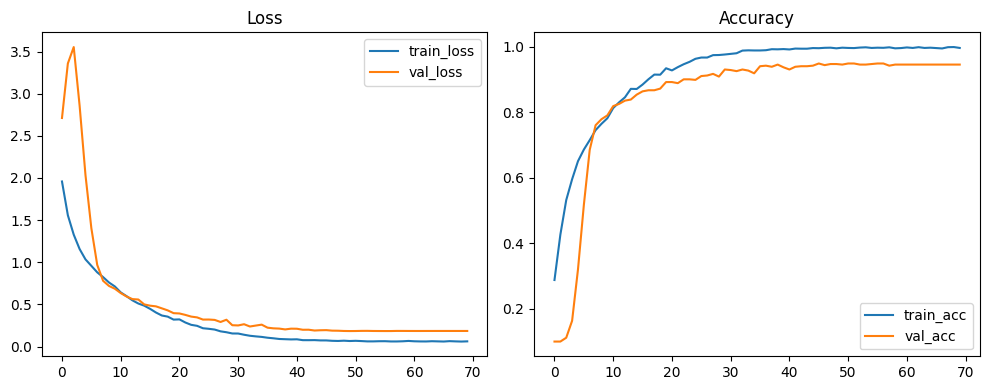

25/25 - 2s - 83ms/step - accuracy: 0.9563 - loss: 0.1715
Test loss: 0.1715  Test accuracy: 0.9563
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 80ms/step

Classification report:

              precision    recall  f1-score   support

       blues       0.95      0.97      0.96        80
   classical       1.00      0.99      0.99        80
     country       0.91      0.91      0.91        80
       disco       0.99      0.91      0.95        80
      hiphop       0.96      0.99      0.98        80
        jazz       0.99      0.99      0.99        80
       metal       0.94      1.00      0.97        80
         pop       0.91      0.97      0.94        80
      reggae       0.95      0.97      0.96        80
        rock       0.97      0.85      0.91        80

    accuracy                           0.96       800
   macro avg       0.96      0.96      0.96       800
weighted avg       0.96      0.96      0.96       800



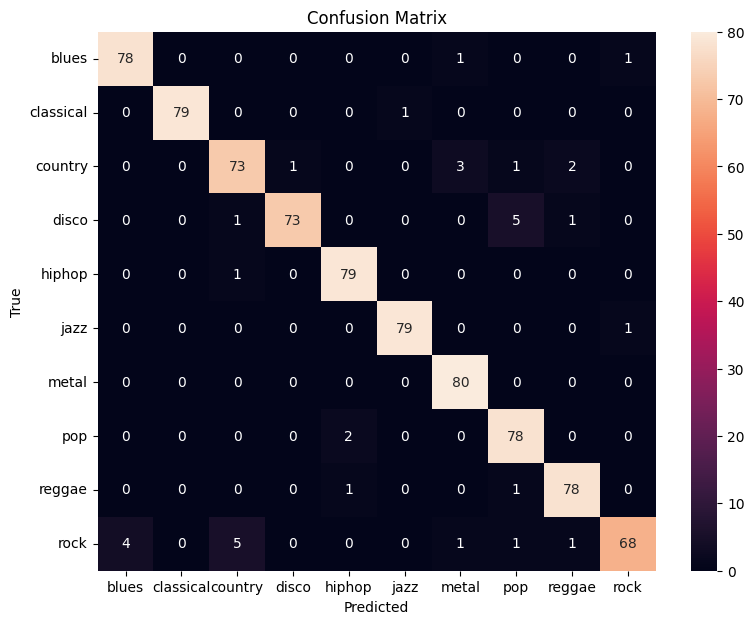

In [11]:
if __name__ == "__main__":
    main()

## Model Correction
(change to SavedModel format / .keras)


In [ ]:
import tensorflow as tf
from tensorflow import keras
import numpy as np

def create_and_save_fixed_model(original_weights_path, output_path='gtzan_model'):
    print("Building model architecture...")

    # Build the exact architecture
    inputs = keras.layers.Input(shape=(128, 1292, 1), name='input_layer')

    # First Conv Block
    x = keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu', name='conv2d')(inputs)
    x = keras.layers.BatchNormalization(name='batch_normalization')(x)
    x = keras.layers.MaxPooling2D((2, 2), name='max_pooling2d')(x)

    # Second Conv Block
    x = keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu', name='conv2d_1')(x)
    x = keras.layers.BatchNormalization(name='batch_normalization_1')(x)
    x = keras.layers.MaxPooling2D((2, 2), name='max_pooling2d_1')(x)

    # Third Conv Block
    x = keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu', name='conv2d_2')(x)
    x = keras.layers.BatchNormalization(name='batch_normalization_2')(x)
    x = keras.layers.MaxPooling2D((2, 2), name='max_pooling2d_2')(x)

    # Use Reshape layer instead of Lambda (more compatible!)
    # From (None, 16, 161, 128) to (None, 161, 2048)
    x = keras.layers.Reshape((161, 2048), name='reshape')(x)

    x = keras.layers.Dropout(0.5, name='dropout')(x)

    # BiLSTM layer with 128 units
    x = keras.layers.Bidirectional(
        keras.layers.LSTM(128, return_sequences=False),
        name='bidirectional'
    )(x)

    x = keras.layers.Dropout(0.5, name='dropout_1')(x)

    # Output layer
    outputs = keras.layers.Dense(10, activation='softmax', name='dense')(x)

    model = keras.Model(inputs=inputs, outputs=outputs)

    print("\n✓ Model architecture created")
    print(f"Input shape: {model.input_shape}")
    print(f"Output shape: {model.output_shape}")

    # Load weights from original model
    print(f"\nLoading weights from {original_weights_path}...")

    try:
        # Use skip_mismatch to automatically skip the Lambda layer
        model.load_weights(original_weights_path, skip_mismatch=True, by_name=True)
        print("✓ Weights loaded successfully!")

        # Verify which layers got weights
        print("\nLayers with loaded weights:")
        for layer in model.layers:
            if len(layer.get_weights()) > 0:
                print(f"  ✓ {layer.name}")

    except Exception as e:
        print(f"✗ Error loading weights: {e}")
        return None

    # Compile the model
    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    # Test the model works
    print("\nTesting model with dummy input...")
    dummy_input = np.random.rand(1, 128, 1292, 1).astype(np.float32)
    predictions = model.predict(dummy_input, verbose=0)
    print(f"✓ Model works! Output shape: {predictions.shape}")

    # Save in Keras 3 native format (.keras)
    print(f"\nSaving model to {output_path}.keras...")
    model.save(f'{output_path}.keras')
    print("✓ Model saved successfully!")

    # Also try to save as H5 for backward compatibility
    try:
        h5_path = output_path + '.h5'
        model.save(h5_path)
        print(f"✓ Also saved as {h5_path}")
    except Exception as e:
        print(f"  (Could not save H5 version: {e})")

    return model


if __name__ == "__main__":
    model = create_and_save_fixed_model(
        original_weights_path='gtzan_best.h5',
        output_path='gtzan_model'
    )

    if model is not None:
        print("\n" + "="*60)
        print("MODEL SUMMARY")
        print("="*60)
        model.summary()

Building model architecture...

✓ Model architecture created
Input shape: (None, 128, 1292, 1)
Output shape: (None, 10)

Loading weights from gtzan_best.h5...
✓ Weights loaded successfully!

Layers with loaded weights:
  ✓ conv2d
  ✓ batch_normalization
  ✓ conv2d_1
  ✓ batch_normalization_1
  ✓ conv2d_2
  ✓ batch_normalization_2
  ✓ bidirectional
  ✓ dense

Testing model with dummy input...


✓ Model works! Output shape: (1, 10)

Saving model to gtzan_model.keras...
✓ Model saved successfully!
✓ Also saved as gtzan_model.h5

MODEL SUMMARY


Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 128, 1292, 1)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 128, 1292, 32)  │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128, 1292, 32)  │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 646, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 646, 64)    │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64, 646, 64)    │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 323, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 323, 128)   │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32, 323, 128)   │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 161, 128)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 161, 2048)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 161, 2048)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 256)            │     2,229,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,325,386 (8.87 MB)

 Trainable params: 2,324,938 (8.87 MB)

 Non-trainable params: 448 (1.75 KB)